# Metric Analysis with Full Dataframe

Data types of the metrics DataFrame after aggregation:
LLM                         object
Total Response Time        float64
Average Chunk Time         float64
Response Rate              float64
Word Count                 float64
Character Count            float64
Sentence Count             float64
Average Word Length        float64
Average Sentence Length    float64
Vocabulary Richness        float64
dtype: object
Plotting Total Response Time per LLM (Sorted):
[('granite3-moe_1b', 15.03), ('moondream2_1.8b', 21.17), ('granite3-moe_3b', 46.59), ('llama3.2_1b', 87.56), ('gemma2_2b', 105.27), ('llama3.2_3b', 117.35), ('qwen2.5_3b', 126.24), ('granite3-dense_2b', 138.87), ('dolphin-llama3_8b', 226.93), ('dolphin-llama3_1b', 239.67000000000002), ('phi3.5_3.8b', 303.32), ('granite3-dense_8b', 387.14), ('qwen2.5_7b', 396.84), ('gemma2_9b', 404.61), ('llama3.1_8b', 411.93)]


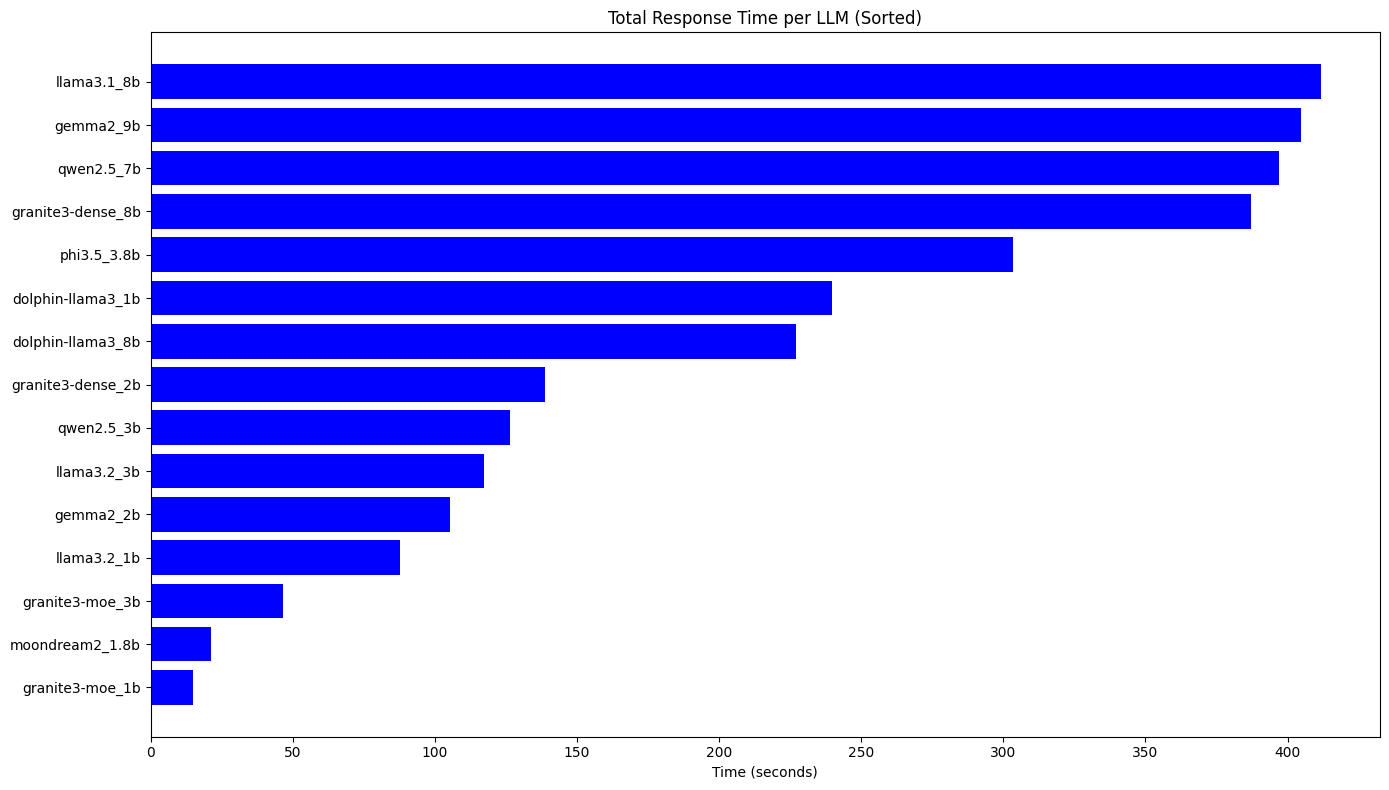

Plotting Average Chunk Time per LLM (Sorted):
[('granite3-moe_1b', 0.033), ('granite3-moe_3b', 0.0622), ('moondream2_1.8b', 0.1224), ('granite3-dense_2b', 0.1232), ('llama3.2_1b', 0.1293), ('gemma2_2b', 0.1313), ('llama3.2_3b', 0.1416), ('qwen2.5_3b', 0.1487), ('phi3.5_3.8b', 0.2227), ('dolphin-llama3_8b', 0.3318), ('qwen2.5_7b', 0.3442), ('gemma2_9b', 0.394), ('llama3.1_8b', 0.40845), ('dolphin-llama3_1b', 0.40895000000000004), ('granite3-dense_8b', 0.4744)]


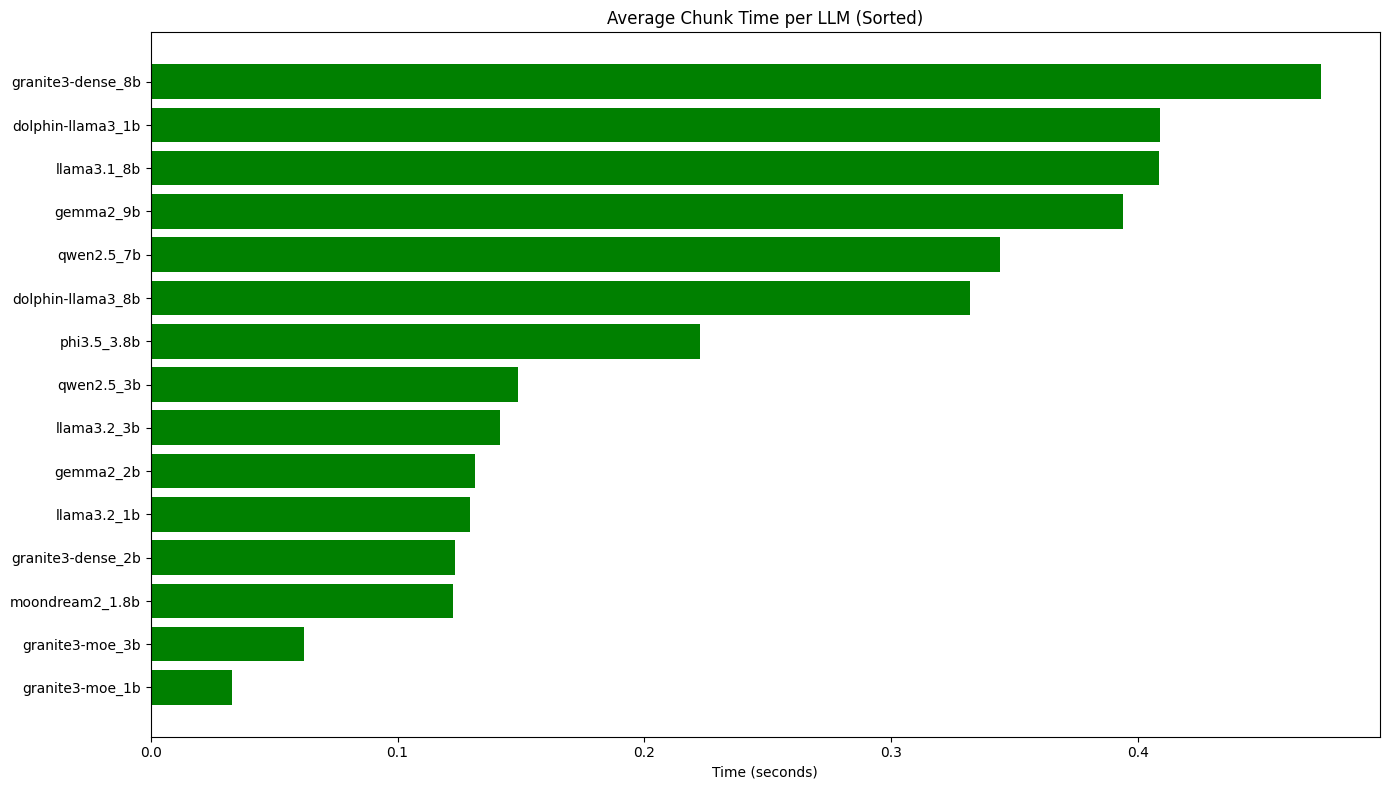

Plotting Response Rate per LLM (Sorted):
[('granite3-dense_8b', 1.0), ('dolphin-llama3_1b', 1.205), ('dolphin-llama3_8b', 1.34), ('gemma2_9b', 1.35), ('llama3.1_8b', 1.395), ('qwen2.5_7b', 1.45), ('moondream2_1.8b', 2.08), ('phi3.5_3.8b', 2.82), ('llama3.2_3b', 3.91), ('qwen2.5_3b', 4.29), ('granite3-dense_2b', 4.32), ('gemma2_2b', 5.01), ('llama3.2_1b', 5.01), ('granite3-moe_3b', 7.6), ('granite3-moe_1b', 16.36)]


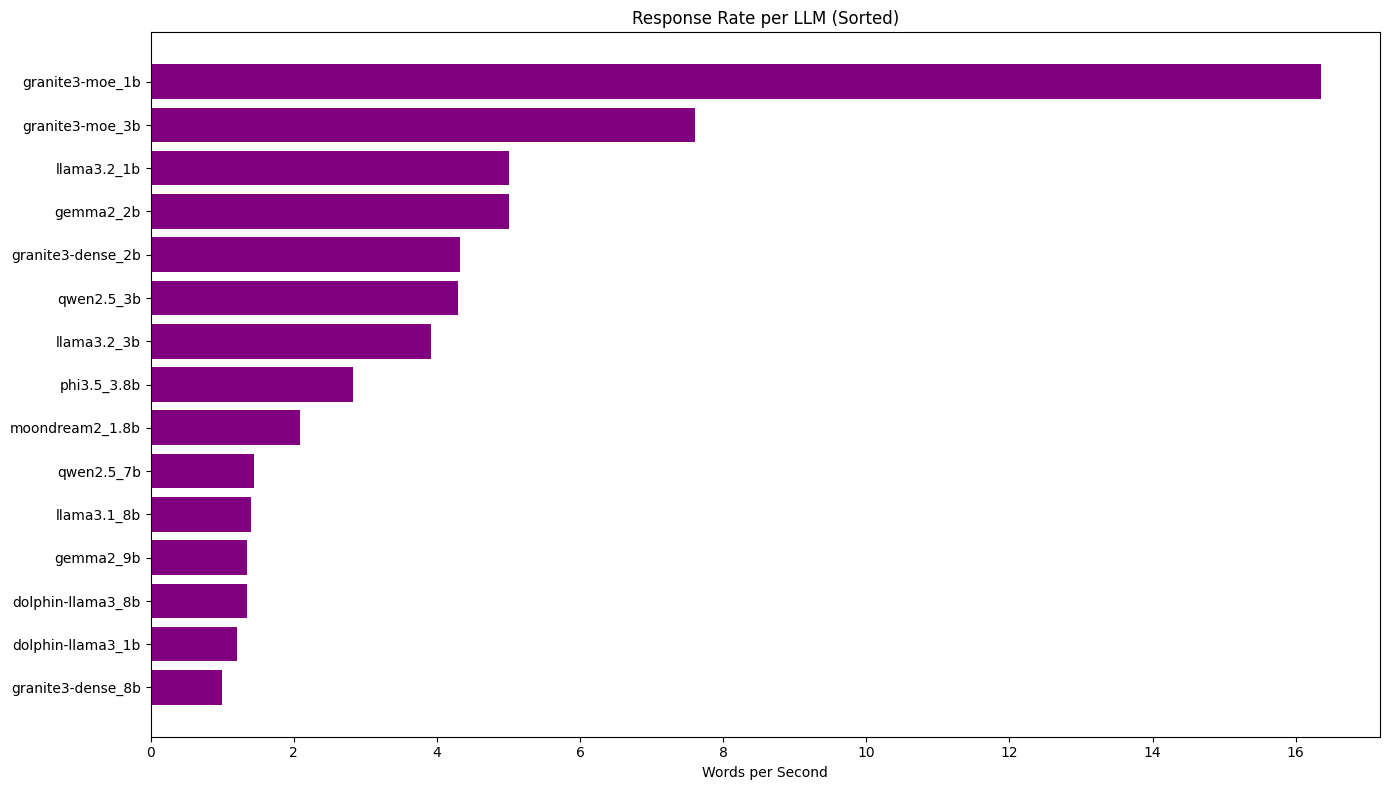

Plotting Word Count per LLM (Sorted):
[('moondream2_1.8b', 44.0), ('granite3-moe_1b', 246.0), ('dolphin-llama3_1b', 278.0), ('dolphin-llama3_8b', 303.0), ('granite3-moe_3b', 354.0), ('granite3-dense_8b', 389.0), ('llama3.2_1b', 443.5), ('llama3.2_3b', 458.0), ('gemma2_2b', 527.0), ('qwen2.5_3b', 542.0), ('gemma2_9b', 546.0), ('llama3.1_8b', 572.0), ('qwen2.5_7b', 576.0), ('granite3-dense_2b', 600.0), ('phi3.5_3.8b', 855.0)]


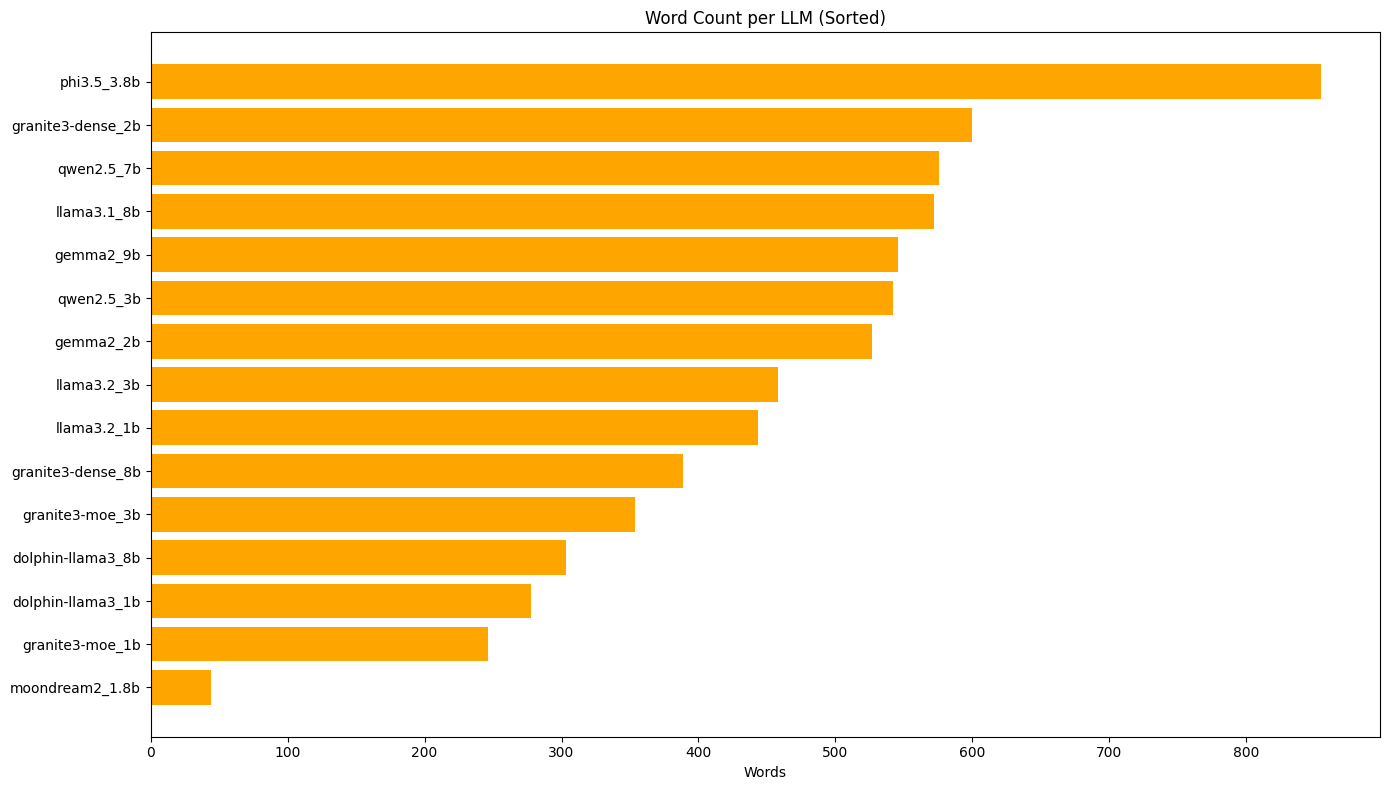

Plotting Character Count per LLM (Sorted):
[('moondream2_1.8b', 320.0), ('granite3-moe_1b', 1706.0), ('dolphin-llama3_1b', 1967.5), ('dolphin-llama3_8b', 1980.0), ('granite3-moe_3b', 2456.0), ('llama3.2_1b', 2594.0), ('granite3-dense_8b', 2768.0), ('llama3.2_3b', 3163.5), ('gemma2_2b', 3756.0), ('qwen2.5_3b', 3916.0), ('gemma2_9b', 4031.0), ('llama3.1_8b', 4050.0), ('granite3-dense_2b', 4116.0), ('qwen2.5_7b', 4295.0), ('phi3.5_3.8b', 6030.0)]


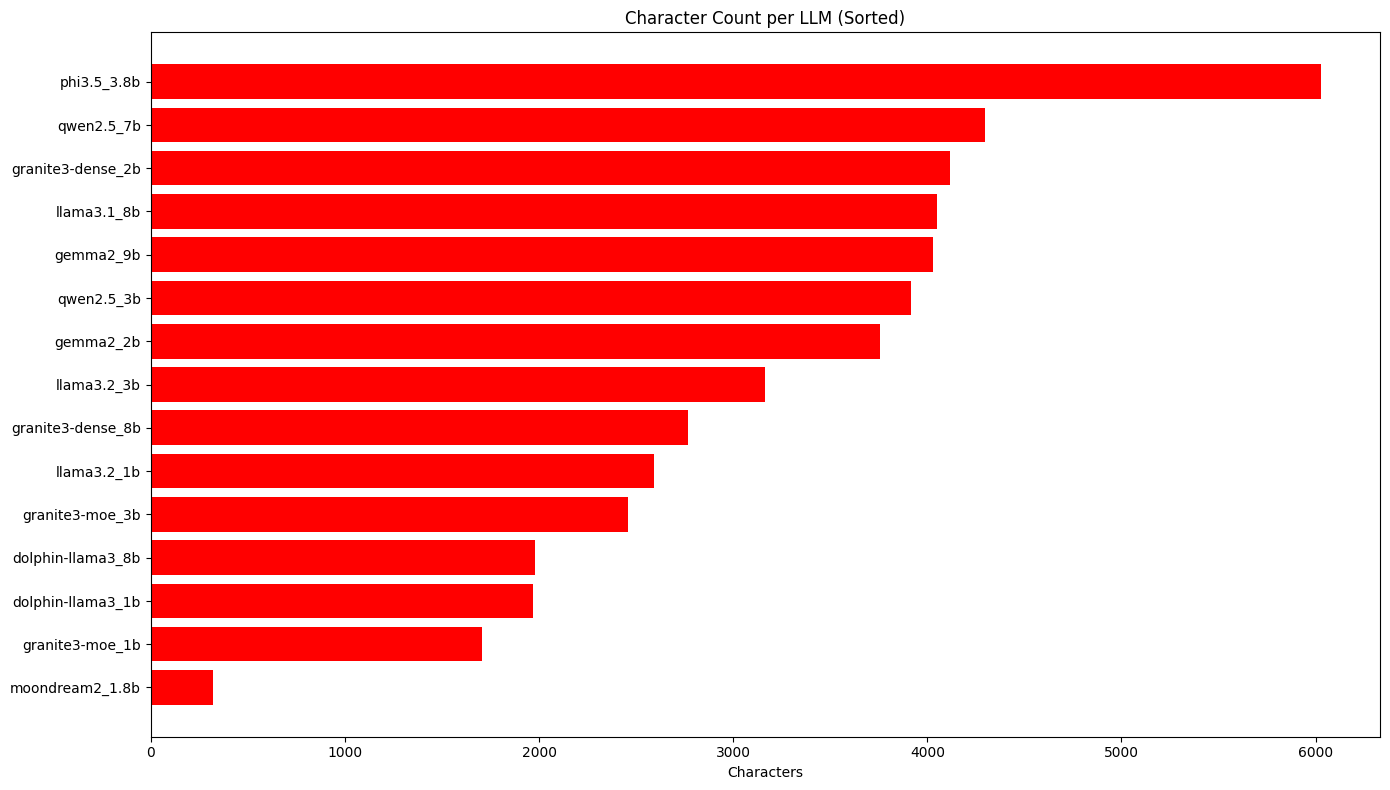

Plotting Sentence Count per LLM (Sorted):
[('moondream2_1.8b', 4.0), ('phi3.5_3.8b', 23.0), ('dolphin-llama3_1b', 25.0), ('qwen2.5_3b', 32.0), ('dolphin-llama3_8b', 34.0), ('granite3-moe_1b', 39.0), ('gemma2_2b', 43.0), ('llama3.2_3b', 45.0), ('llama3.2_1b', 46.0), ('llama3.1_8b', 51.5), ('granite3-moe_3b', 54.0), ('granite3-dense_8b', 61.0), ('qwen2.5_7b', 62.0), ('gemma2_9b', 71.0), ('granite3-dense_2b', 75.0)]


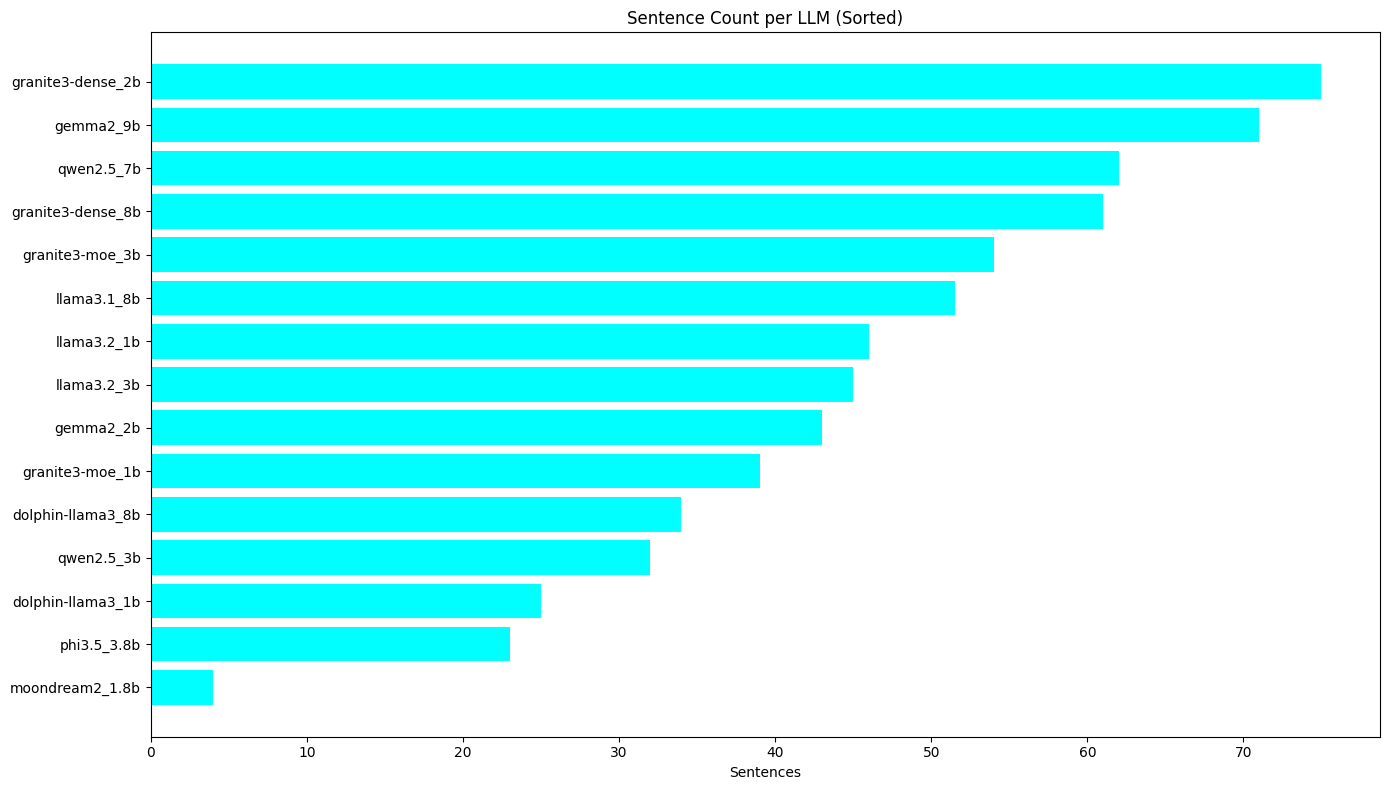

Plotting Average Word Length per LLM (Sorted):
[('llama3.2_1b', 5.825), ('dolphin-llama3_8b', 6.53), ('granite3-dense_2b', 6.86), ('dolphin-llama3_1b', 6.915), ('llama3.2_3b', 6.915), ('granite3-moe_1b', 6.93), ('granite3-moe_3b', 6.94), ('phi3.5_3.8b', 7.05), ('llama3.1_8b', 7.109999999999999), ('granite3-dense_8b', 7.12), ('gemma2_2b', 7.13), ('qwen2.5_3b', 7.23), ('moondream2_1.8b', 7.27), ('gemma2_9b', 7.38), ('qwen2.5_7b', 7.46)]


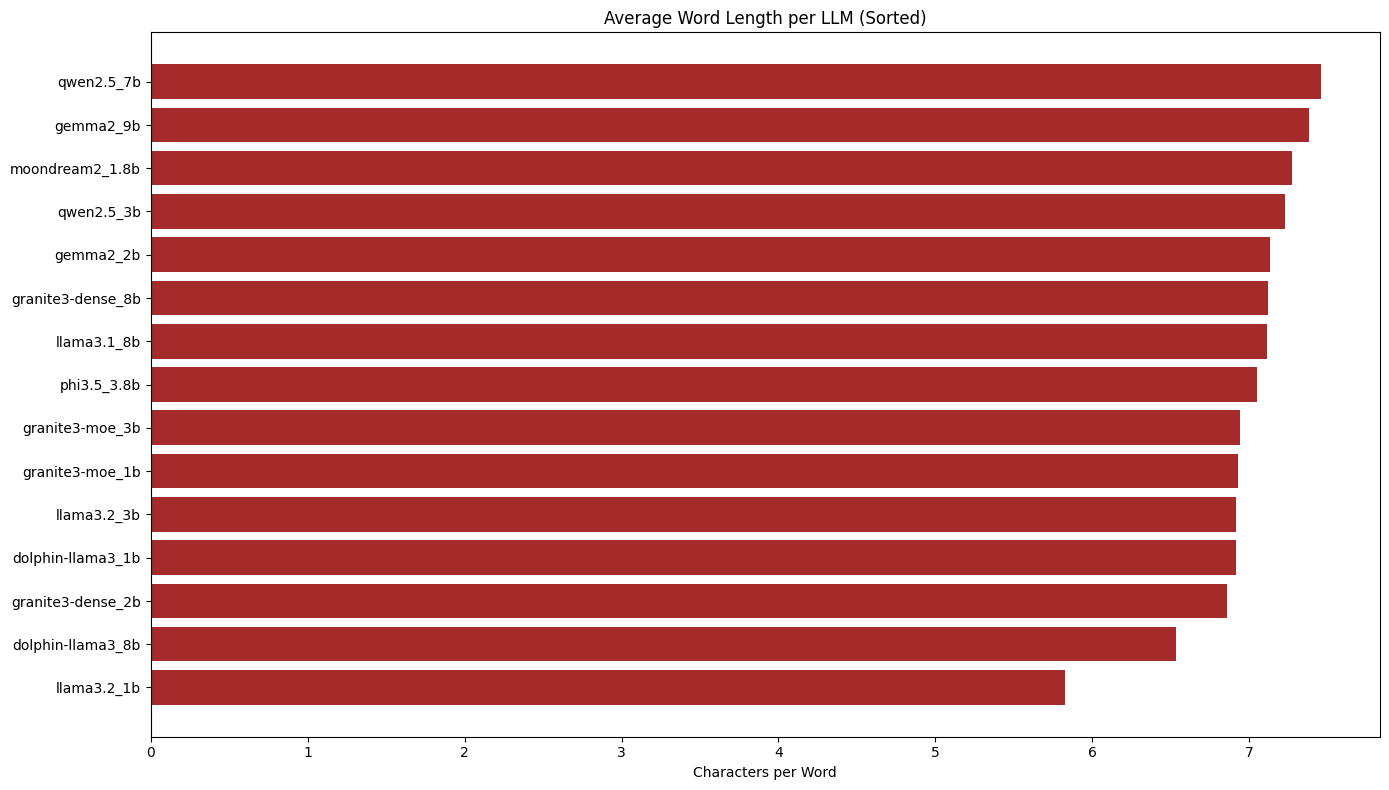

Plotting Average Sentence Length per LLM (Sorted):
[('granite3-moe_1b', 6.31), ('granite3-dense_8b', 6.38), ('granite3-moe_3b', 6.56), ('gemma2_9b', 7.69), ('granite3-dense_2b', 8.0), ('dolphin-llama3_8b', 8.91), ('qwen2.5_7b', 9.29), ('llama3.2_1b', 9.95), ('llama3.2_3b', 10.18), ('dolphin-llama3_1b', 10.845), ('moondream2_1.8b', 11.0), ('llama3.1_8b', 12.235), ('gemma2_2b', 12.26), ('qwen2.5_3b', 16.94), ('phi3.5_3.8b', 37.17)]


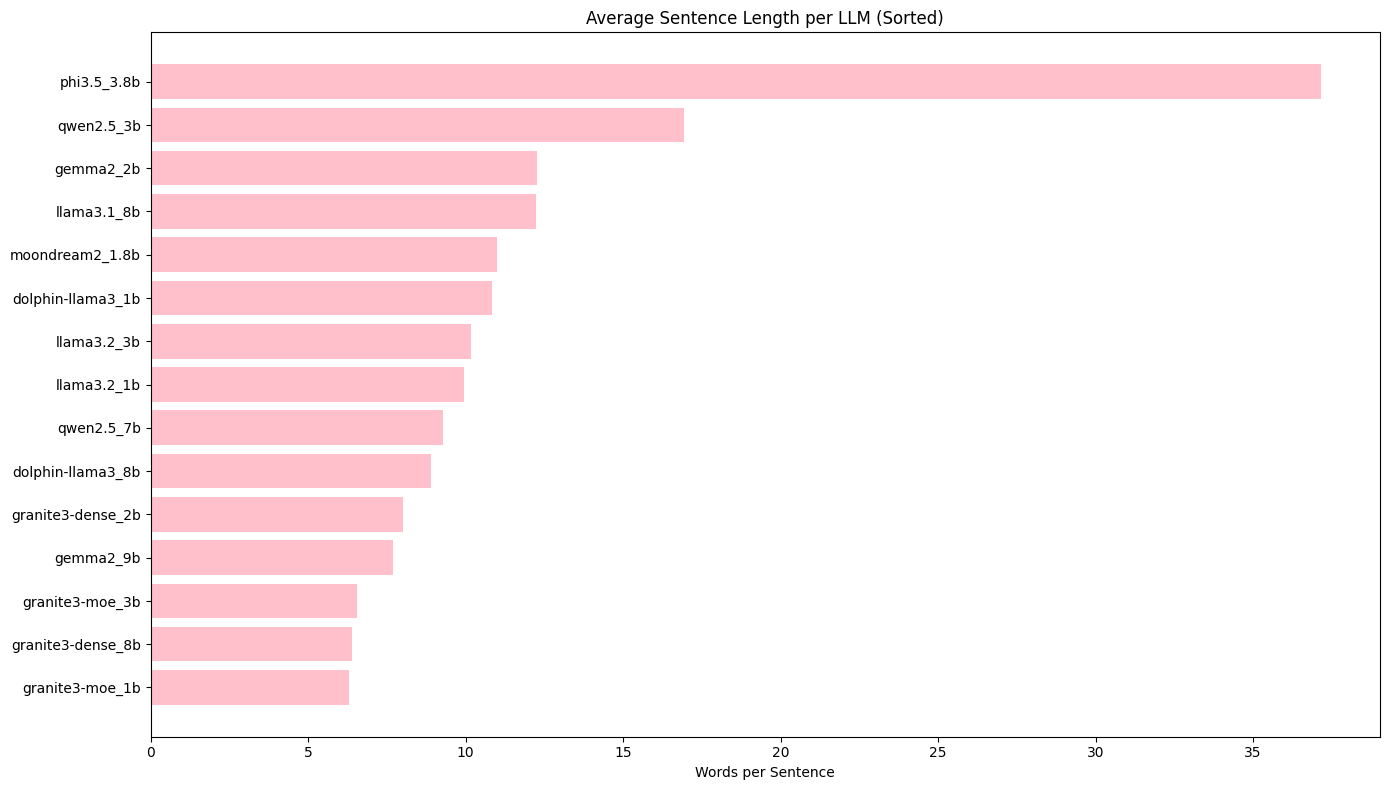

Plotting Vocabulary Richness per LLM (Sorted):
[('granite3-dense_2b', 0.225), ('llama3.2_1b', 0.2484), ('llama3.1_8b', 0.31365), ('moondream2_1.8b', 0.3182), ('granite3-dense_8b', 0.3213), ('qwen2.5_3b', 0.3339), ('dolphin-llama3_8b', 0.3498), ('granite3-moe_1b', 0.374), ('granite3-moe_3b', 0.3757), ('gemma2_9b', 0.3791), ('llama3.2_3b', 0.38315), ('dolphin-llama3_1b', 0.3872), ('qwen2.5_7b', 0.4115), ('phi3.5_3.8b', 0.4187), ('gemma2_2b', 0.4364)]


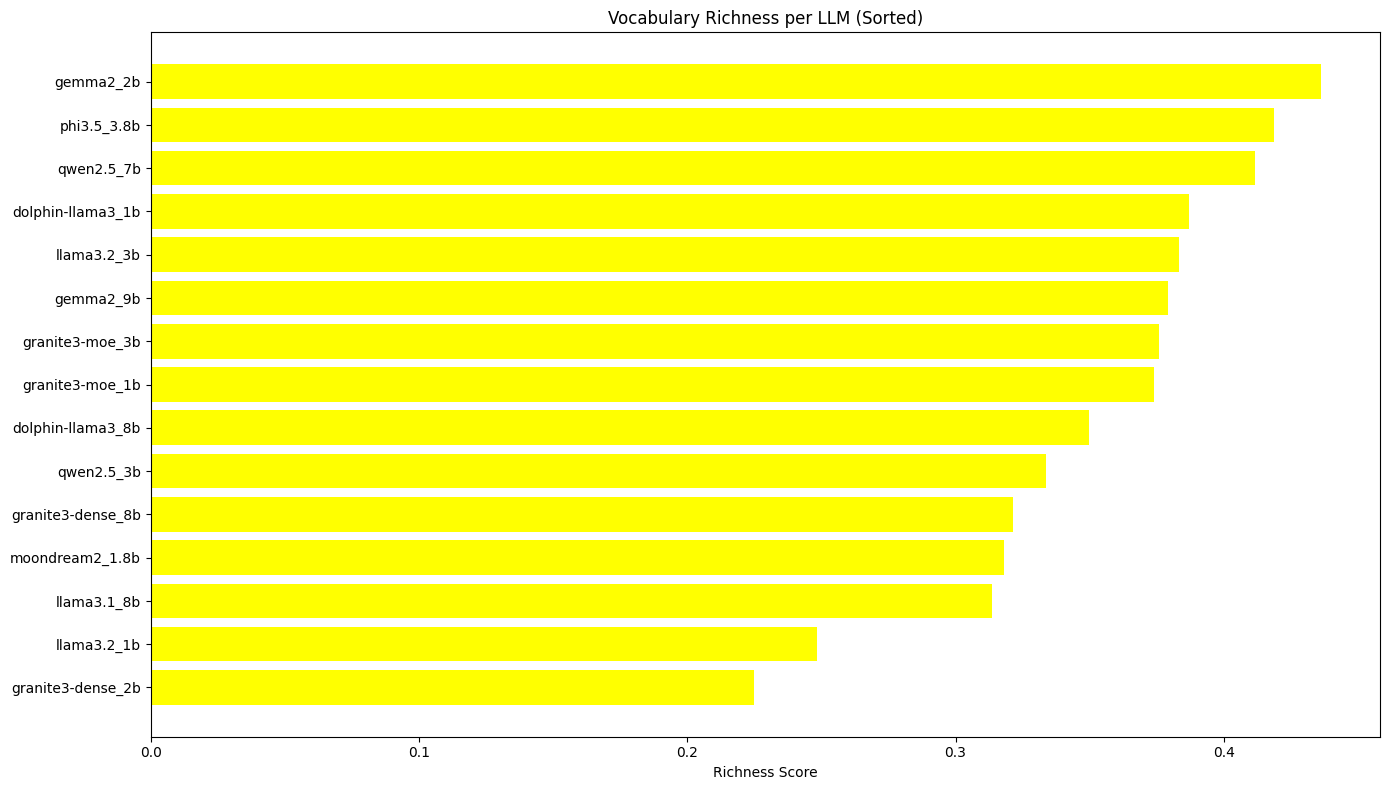

In [19]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Get the current working directory
current_dir = os.getcwd()

# Path to the metrics directory
metrics_dir = os.path.abspath(os.path.join(current_dir, '../../data/processed/'))

# Check if the directory exists
if not os.path.exists(metrics_dir):
    print(f"Error: The directory {metrics_dir} does not exist.")
else:
    # Define lists to store the metrics
    llm_names = []
    response_times = []
    chunk_times = []
    response_rates = []
    word_counts = []
    char_counts = []
    sentence_counts = []
    avg_word_lengths = []
    avg_sentence_lengths = []
    vocab_richnesses = []

    # Regular expressions to extract the metrics
    metrics_regex = {
        'Total Response Time': r'Total Response Time: ([\d.]+)',
        'Average Chunk Time': r'Average Chunk Time: ([\d.]+)',
        'Response Rate': r'Response Rate: ([\d.]+)',
        'Word Count': r'Word Count: (\d+)',
        'Character Count': r'Character Count: (\d+)',
        'Sentence Count': r'Sentence Count: (\d+)',
        'Average Word Length': r'Average Word Length: ([\d.]+)',
        'Average Sentence Length': r'Average Sentence Length: ([\d.]+)',
        'Vocabulary Richness': r'Vocabulary Richness: ([\d.]+)'
    }

    # Loop through all text files in the directory
    for filename in os.listdir(metrics_dir):
        if filename.endswith('.txt'):
            # Extract only the relevant parts of the filename
            parts = filename.split('_')  # Split the filename by underscores
            llm_name = f"{parts[0]}_{parts[1]}"  # Keep only the first two parts (e.g., llama3.1_8b)
            llm_names.append(llm_name)

            with open(os.path.join(metrics_dir, filename), 'r') as file:
                content = file.read()

                # Extract each metric using regular expressions
                try:
                    response_time = float(re.search(metrics_regex['Total Response Time'], content).group(1))
                    chunk_time = float(re.search(metrics_regex['Average Chunk Time'], content).group(1))
                    response_rate = float(re.search(metrics_regex['Response Rate'], content).group(1))
                    word_count = int(re.search(metrics_regex['Word Count'], content).group(1))
                    char_count = int(re.search(metrics_regex['Character Count'], content).group(1))
                    sentence_count = int(re.search(metrics_regex['Sentence Count'], content).group(1))
                    avg_word_length = float(re.search(metrics_regex['Average Word Length'], content).group(1))
                    avg_sentence_length = float(re.search(metrics_regex['Average Sentence Length'], content).group(1))
                    vocab_richness = float(re.search(metrics_regex['Vocabulary Richness'], content).group(1))
                except (AttributeError, ValueError):
                    # Handle missing or invalid data by skipping the file
                    print(f"Warning: Invalid or missing data in file {filename}. Skipping.")
                    continue

                # Append the extracted values to the respective lists
                response_times.append(response_time)
                chunk_times.append(chunk_time)
                response_rates.append(response_rate)
                word_counts.append(word_count)
                char_counts.append(char_count)
                sentence_counts.append(sentence_count)
                avg_word_lengths.append(avg_word_length)
                avg_sentence_lengths.append(avg_sentence_length)
                vocab_richnesses.append(vocab_richness)

    # Create a DataFrame to store the extracted metrics
    metrics_df = pd.DataFrame({
        'LLM': llm_names,
        'Total Response Time': response_times,
        'Average Chunk Time': chunk_times,
        'Response Rate': response_rates,
        'Word Count': word_counts,
        'Character Count': char_counts,
        'Sentence Count': sentence_counts,
        'Average Word Length': avg_word_lengths,
        'Average Sentence Length': avg_sentence_lengths,
        'Vocabulary Richness': vocab_richnesses
    })

    # Force all metric columns to be numeric
    for column in metrics_df.columns[1:]:
        metrics_df[column] = pd.to_numeric(metrics_df[column], errors='coerce')

    # Remove any rows with NaN values
    metrics_df.dropna(inplace=True)

    # Aggregate metrics for duplicate LLMs by averaging them
    metrics_df = metrics_df.groupby('LLM', as_index=False).mean()

    # Double-check the data types of each column
    print("Data types of the metrics DataFrame after aggregation:")
    print(metrics_df.dtypes)

    # Function to sort by a given metric and plot in ascending order
    def plot_metric(df, metric, color, ylabel, title, horizontal=False):
        # Sort the DataFrame by the specified metric in ascending order
        df_sorted = df.sort_values(by=metric, ascending=True)

        # Extract sorted values for plotting
        sorted_llm_names = df_sorted['LLM'].tolist()
        sorted_metric_values = df_sorted[metric].tolist()

        # Debugging: Print the sorted values to verify
        print(f"Plotting {title}:")
        print(list(zip(sorted_llm_names, sorted_metric_values)))

        # Plot the sorted data, allowing for horizontal bars if specified
        plt.figure(figsize=(14, 8))  # Increase the figure width for better label spacing
        if horizontal:
            plt.barh(sorted_llm_names, sorted_metric_values, color=color)
            plt.xlabel(ylabel)
        else:
            plt.bar(sorted_llm_names, sorted_metric_values, color=color)
            plt.ylabel(ylabel)
            plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-ticks for readability

        plt.title(title)
        plt.tight_layout()
        plt.show()

    # Plot each metric, ensuring they are sorted from smallest to largest based on the y-axis metric
    plot_metric(metrics_df, 'Total Response Time', 'blue', 'Time (seconds)', 'Total Response Time per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Average Chunk Time', 'green', 'Time (seconds)', 'Average Chunk Time per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Response Rate', 'purple', 'Words per Second', 'Response Rate per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Word Count', 'orange', 'Words', 'Word Count per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Character Count', 'red', 'Characters', 'Character Count per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Sentence Count', 'cyan', 'Sentences', 'Sentence Count per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Average Word Length', 'brown', 'Characters per Word', 'Average Word Length per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Average Sentence Length', 'pink', 'Words per Sentence', 'Average Sentence Length per LLM (Sorted)', horizontal=True)
    plot_metric(metrics_df, 'Vocabulary Richness', 'yellow', 'Richness Score', 'Vocabulary Richness per LLM (Sorted)', horizontal=True)
